<div class="alert alert-info">
    
# A/B-тестирование

<div style="border:solid green 2px; padding: 20px">
<b>Постановка задачи</b>

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:
- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

<div style="border:solid green 2px; padding: 20px">
<b>Техническое задание</b>

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

<div style="border:solid green 2px; padding: 20px">
<b>Описание данных</b>

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

<div class="alert alert-info">

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from plotly import graph_objects as go 
import plotly.express as px
from scipy import stats as st
import scipy.stats as stats

In [2]:
try:
    ab_project_marketing_events = pd.read_csv('ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt'])
    final_ab_new_users = pd.read_csv('final_ab_new_users.csv', parse_dates=['first_date'])
    final_ab_events = pd.read_csv('final_ab_events.csv', parse_dates=['event_dt'])
    final_ab_participants = pd.read_csv('final_ab_participants.csv')
except:
    ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt'])
    final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv', parse_dates=['first_date'])
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv', parse_dates=['event_dt'])
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
    
    

In [3]:
def get_info(df):
    df.info()
    display(df.head())
    display(df.isna().sum())

In [4]:
def dublicate_check(df):
    dublicate_count = df.duplicated().sum()
    if dublicate_count > 0:
        print('в датафрейме найдены дубли:', dublicate_count)
    else:
        print('дублей не обнаружено')

In [5]:
get_info(ab_project_marketing_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [6]:
dublicate_check(ab_project_marketing_events)

дублей не обнаружено


In [7]:
get_info(final_ab_new_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


user_id       0
first_date    0
region        0
device        0
dtype: int64

In [8]:
dublicate_check(final_ab_new_users)

дублей не обнаружено


In [9]:
get_info(final_ab_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

🧑‍🎓 Ира: Пропуски здесь можно объяснить тем, что не для каждого события будут писать доп инфо, так как в этом нет смысла

In [10]:
dublicate_check(final_ab_events)

дублей не обнаружено


In [11]:
get_info(final_ab_participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


user_id    0
group      0
ab_test    0
dtype: int64

In [12]:
dublicate_check(final_ab_participants)

дублей не обнаружено


In [13]:
def unique_var(df, column):
    return len(df[column].unique()), df[column].unique()

In [14]:
unique_events_count, unique_events_list = unique_var(ab_project_marketing_events, 'name')
print('Кол-во уникальных значений в столбце event =', unique_events_count)
unique_events_list

Кол-во уникальных значений в столбце event = 14


array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

In [15]:
unique_regions_count, unique_regions_list = unique_var(ab_project_marketing_events, 'regions')
print('Кол-во уникальных значений в столбце event =', unique_regions_count)
unique_regions_list

Кол-во уникальных значений в столбце event = 6


array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [16]:
unique_ab_regions_count, unique_ab_regions_list = unique_var(final_ab_new_users, 'region')
print('Кол-во уникальных значений в столбце event =', unique_ab_regions_count)
unique_ab_regions_list

Кол-во уникальных значений в столбце event = 4


array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [17]:
unique_ab_device_count, unique_ab_device_list = unique_var(final_ab_new_users, 'device')
print('Кол-во уникальных значений в столбце event =', unique_ab_device_count)
unique_ab_device_list

Кол-во уникальных значений в столбце event = 4


array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [18]:
unique_ab_events_count, unique_ab_events_list = unique_var(final_ab_events, 'event_name')
print('Кол-во уникальных значений в столбце event =', unique_ab_events_count)
unique_ab_events_list

Кол-во уникальных значений в столбце event = 4


array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

<div class="alert alert-info">

## Оцените корректность проведения теста.

In [19]:
start = pd.to_datetime('2020-12-07')
end = pd.to_datetime('2021-01-04')
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


🧑‍🎓 Ира: Выходит, что наш тест совпадает со временем проведения другой маркетинговой кампании

<div class="alert alert-info">

## % Пользователей из региона Европа

требование: 15% новых пользователей из региона EU

In [20]:
ab_new_users_region_count = final_ab_new_users.groupby('region')['user_id'].nunique().reset_index()
ab_new_users_region_count

,region,user_id
0,APAC,3153
1,CIS,3155
2,EU,46270
3,N.America,9155


In [21]:
ab_events_first_ts = (
    final_ab_events.sort_values(by=['user_id', 'event_dt'])
    .groupby(['user_id'])
    .agg(
        {
            'event_dt': 'first',
        }
    )
    .rename(columns={'event_dt': 'first_ts'})
    .reset_index()
)

ab_events_last_ts = (
    final_ab_events.sort_values(by=['user_id', 'event_dt'])
    .groupby(['user_id'])
    .agg(
        {
            'event_dt': 'last',
        }
    )
    .rename(columns={'event_dt': 'last_ts'})
    .reset_index()
)

days_active = ab_events_first_ts.merge(ab_events_last_ts, left_on='user_id', right_on='user_id', suffixes=('', '_y'), how='left')
days_active = days_active.drop(days_active.filter(regex='_y$').columns, axis=1)
days_active['days'] = ((days_active['last_ts'] - days_active['first_ts']) / np.timedelta64(1,'D')).astype(int)
two_weeks_active_users = days_active.query('days <= 14')['user_id'].unique()



In [22]:
#для начала объединим данные о группах юзеров с данными о действиях юзеров в период проведения теста
ab_events_user = final_ab_events.merge(
    final_ab_participants.query('ab_test == "recommender_system_test"'), 
    on ='user_id', how='inner')

#далее объеденим с инфо о юзерах, зарегестрированных в период набора
ab_events_user = ab_events_user.merge(final_ab_new_users, on ='user_id', how='inner')

ab_events_user = ab_events_user.query('user_id in @two_weeks_active_users')
ab_events_user['event_date'] = pd.to_datetime(ab_events_user['event_dt']).dt.date


In [23]:
ab_events_user_region_count = ab_events_user.groupby('region')['user_id'].nunique().reset_index()
ab_events_user_region_count = ab_events_user_region_count.merge(ab_new_users_region_count, on='region', how='inner')
ab_events_user_region_count['new_to_ab_prop'] = ab_events_user_region_count['user_id_x'] / ab_events_user_region_count['user_id_y'] * 100
ab_events_user_region_count


,region,user_id_x,user_id_y,new_to_ab_prop
0,APAC,42,3153,1.332065
1,CIS,27,3155,0.855784
2,EU,3259,46270,7.043441
3,N.America,111,9155,1.212452


🧑‍🎓 Ира: Для проверки ТЗ была найдена доля новых уникальных пользователей, участвовавших в тесте, к общему кол-ву новых пользователей сайта в период проведения теста.  
Из всех новых пользователей за указанный период лишь малая часть попала в финальную выборку.  
Из региона Европа в тесте участвовали лишь 7% новых клиентов сайта  

In [24]:
ab_events_user_a = ab_events_user.query('group == "A"')
ab_events_user_b = ab_events_user.query('group == "B"')
print('A group', ab_events_user_a.shape)
print('B group', ab_events_user_b.shape)
print('B to A group prop =', ab_events_user_b.shape[0] / ab_events_user_a.shape[0])

A group (18217, 10)
B group (4527, 10)
B to A group prop = 0.24850414448043037


In [25]:
b_group_users = ab_events_user_b['user_id'].unique()
check_a_group = ab_events_user_a.query('user_id in @b_group_users')
check_a_group

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,event_date


<div style="border:solid blue 1px; padding: 10px">
<b>Краткий вывод</b>
    
    Если делать краткий общий вывод по первоначальной проверке, выглядит все не очень радужно на мой взгляд:
    - очень большая разница в кол-ве пользователей между группами  
    - во время проведегния теста была запущена еще одна рекламная кампания, и не смотря на то, что группы к этому времени уже набрались, они могли совершать покупки как раз руководствуясь предложениями этой кампании  

<div class="alert alert-info">

## Исследовательский анализ по группам теста

In [26]:
user_aggregated = ab_events_user.pivot_table(
    index=['event_date', 'group'],
    columns='event_name',
    values='user_id',
    aggfunc='nunique'
    
).reset_index()
user_aggregated.index.name = None
user_aggregated.head()

event_name,event_date,group,login,product_cart,product_page,purchase
0,2020-12-07,A,113,23,71,33
1,2020-12-07,B,108,31,69,38
2,2020-12-08,A,121,32,79,26
3,2020-12-08,B,92,24,48,26
4,2020-12-09,A,134,43,81,40


In [27]:
event_aggregated = ab_events_user.pivot_table(
    index=['event_date', 'group'],
    values='event_name',
    aggfunc='count'
    
).reset_index()
event_aggregated.index.name = None
event_aggregated.head()

,event_date,group,event_name
0,2020-12-07,A,240
1,2020-12-07,B,246
2,2020-12-08,A,258
3,2020-12-08,B,190
4,2020-12-09,A,298


In [28]:
user_event_aggregated = ab_events_user.pivot_table(
    index=['event_date', 'group', 'user_id'],
    values='event_name',
    aggfunc='count'
    
).reset_index()
user_event_aggregated.index.name = None
user_event_aggregated = user_event_aggregated.groupby(['event_date', 'group'])['event_name'].mean().reset_index()
user_event_aggregated.head()




,event_date,group,event_name
0,2020-12-07,A,2.123894
1,2020-12-07,B,2.196429
2,2020-12-08,A,2.114754
3,2020-12-08,B,2.043011
4,2020-12-09,A,2.223881


In [29]:
def plot_line(a_x, a_y, b_x, b_y, x_label, y_label, title, axis=[None, None, None, None]):
    plt.figure(figsize=(10, 5)) 
    
    plt.plot(a_x, a_y, label='A')
    
    plt.plot(b_x, b_y, label='B')
    plt.axis(axis)
    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

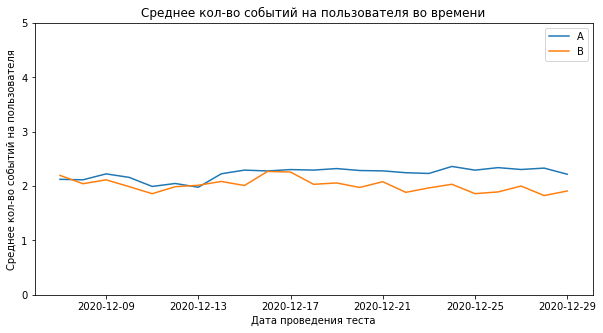

In [30]:
title = 'Среднее кол-во событий на пользователя во времени'
x_label = 'Дата проведения теста'
y_label = 'Среднее кол-во событий на пользователя'
a_x = user_event_aggregated.query('group == "A"')['event_date']
a_y = user_event_aggregated.query('group == "A"')['event_name']
b_x = user_event_aggregated.query('group == "B"')['event_date']
b_y = user_event_aggregated.query('group == "B"')['event_name']
plot_line(a_x, a_y, b_x, b_y, x_label, y_label, title, [None, None, 0, 5])

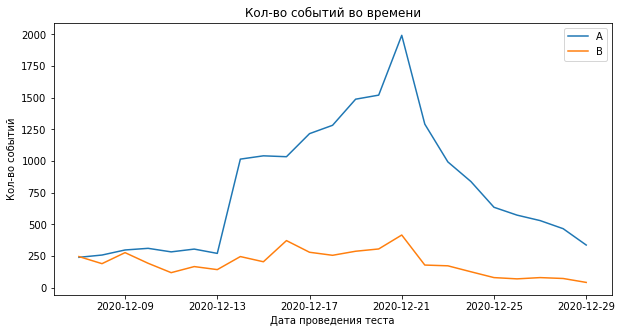

In [31]:
title = 'Кол-во событий во времени'
x_label = 'Дата проведения теста'
y_label = 'Кол-во событий'
a_x = event_aggregated.query('group == "A"')['event_date']
a_y = event_aggregated.query('group == "A"')['event_name']
b_x = event_aggregated.query('group == "B"')['event_date']
b_y = event_aggregated.query('group == "B"')['event_name']
plot_line(a_x, a_y, b_x, b_y, x_label, y_label, title)

🧑‍🎓 Ира:  
я предполагаю, что пользователи могут "прыгать" между событиями, и не обязательно, что все 4 события были каждым пользователем выполнены. Это так же видно по диаграмме среднего кол-ва событий на юзера.  
Например, если пользователь уже зарегестрирован на сайте, и у него уже собрана корзина, он может залогиниться, перейти в корзину и сразу пойти в покупку, пропустив просмотр карточки товара.  
Так же я делаю предположение, что нельзя сразу после логина идти в покупку, скорее всего для этого необходимо перейти в корзину и оттуда нажать "оплатить".  

Исходя из этих предположений, я посчитаю конверсию логин-карточка-корзина-покупка, а так же логин-корзина-покупка

In [32]:
user_aggregated['login_product_conversion'] = user_aggregated['product_page'] / user_aggregated['login']
user_aggregated['product_cart_conversion'] = user_aggregated['product_cart'] / user_aggregated['product_page']
user_aggregated['login_cart_conversion'] = user_aggregated['product_cart'] / user_aggregated['login']
user_aggregated['cart_purchase_conversion'] = user_aggregated['purchase'] / user_aggregated['product_cart']


In [33]:
user_aggregated.head()

event_name,event_date,group,login,product_cart,product_page,purchase,login_product_conversion,product_cart_conversion,login_cart_conversion,cart_purchase_conversion
0,2020-12-07,A,113,23,71,33,0.628319,0.323944,0.203540,1.434783
1,2020-12-07,B,108,31,69,38,0.638889,0.449275,0.287037,1.225806
2,2020-12-08,A,121,32,79,26,0.652893,0.405063,0.264463,0.812500
3,2020-12-08,B,92,24,48,26,0.521739,0.500000,0.260870,1.083333
4,2020-12-09,A,134,43,81,40,0.604478,0.530864,0.320896,0.930233


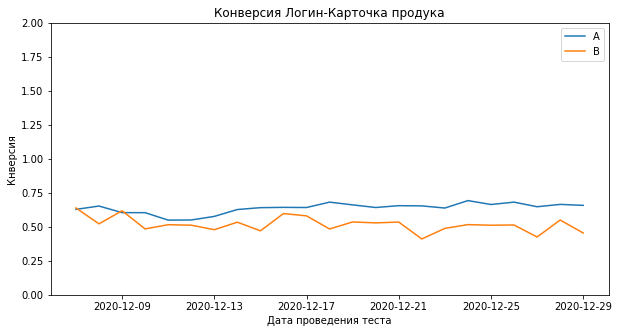

In [34]:
title = 'Конверсия Логин-Карточка продука'
x_label = 'Дата проведения теста'
y_label = 'Кнверсия'
a_x = user_aggregated.query('group == "A"')['event_date']
a_y = user_aggregated.query('group == "A"')['login_product_conversion']
b_x = user_aggregated.query('group == "B"')['event_date']
b_y = user_aggregated.query('group == "B"')['login_product_conversion']
plot_line(a_x, a_y, b_x, b_y, x_label, y_label, title, [None, None, 0, 2])

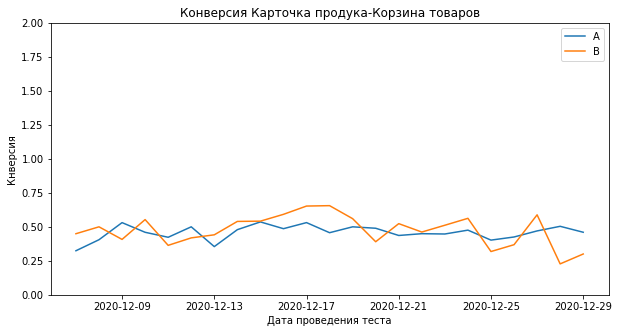

In [35]:
title = 'Конверсия Карточка продука-Корзина товаров'
x_label = 'Дата проведения теста'
y_label = 'Кнверсия'
a_x = user_aggregated.query('group == "A"')['event_date']
a_y = user_aggregated.query('group == "A"')['product_cart_conversion']
b_x = user_aggregated.query('group == "B"')['event_date']
b_y = user_aggregated.query('group == "B"')['product_cart_conversion']
plot_line(a_x, a_y, b_x, b_y, x_label, y_label, title, [None, None, 0, 2])

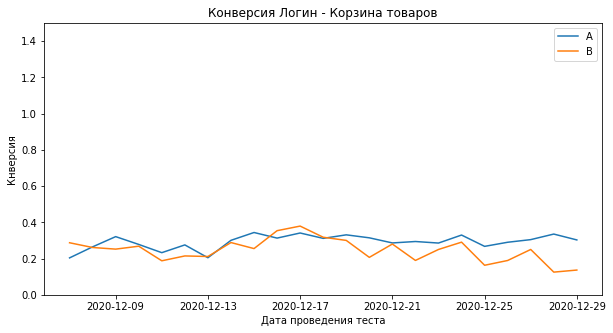

In [36]:
title = 'Конверсия Логин - Корзина товаров'
x_label = 'Дата проведения теста'
y_label = 'Кнверсия'
a_x = user_aggregated.query('group == "A"')['event_date']
a_y = user_aggregated.query('group == "A"')['login_cart_conversion']
b_x = user_aggregated.query('group == "B"')['event_date']
b_y = user_aggregated.query('group == "B"')['login_cart_conversion']
plot_line(a_x, a_y, b_x, b_y, x_label, y_label, title, [None, None, 0, 1.5])

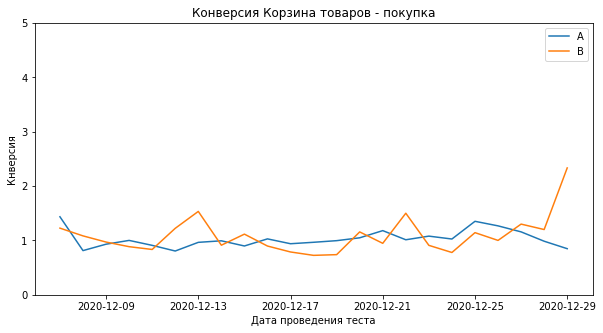

In [37]:
title = 'Конверсия Корзина товаров - покупка'
x_label = 'Дата проведения теста'
y_label = 'Кнверсия'
a_x = user_aggregated.query('group == "A"')['event_date']
a_y = user_aggregated.query('group == "A"')['cart_purchase_conversion']
b_x = user_aggregated.query('group == "B"')['event_date']
b_y = user_aggregated.query('group == "B"')['cart_purchase_conversion']
plot_line(a_x, a_y, b_x, b_y, x_label, y_label, title, [None, None, 0, 5])

🧑‍🎓 Ира: конверсия в группе А почти всегда выше, чем в группе В.  
    Конверсия корзина-покупка в группах колеблется, но тоже группе А удается немного лидировать. 

<div style="border:solid blue 1px; padding: 10px">
<b>Краткий вывод</b>
    
    Независимо от группы пользователи делают в среднем 2-3 события.  
    Кол-во событий во времени в группе А логично больше, так как в ней оказалось больше пользователей.  
    Конверсия в группе А тоже выше, но не намного и не всегда.  

<div class="alert alert-info">

## Оцените результаты A/B-тестирования

🧑‍🎓 Ира: Необходимо проверить статистическую разницу долей в группах.  
    Для начала сформулируем гипотезу:  
        нулевая гипотеза: Доля пользователей, совершивших конкретное событие в группах не отличается   
        альтернативная: Доля пользователей, совершивших конкретное событие в группах отличается 

In [38]:
user_aggregated.head()

event_name,event_date,group,login,product_cart,product_page,purchase,login_product_conversion,product_cart_conversion,login_cart_conversion,cart_purchase_conversion
0,2020-12-07,A,113,23,71,33,0.628319,0.323944,0.203540,1.434783
1,2020-12-07,B,108,31,69,38,0.638889,0.449275,0.287037,1.225806
2,2020-12-08,A,121,32,79,26,0.652893,0.405063,0.264463,0.812500
3,2020-12-08,B,92,24,48,26,0.521739,0.500000,0.260870,1.083333
4,2020-12-09,A,134,43,81,40,0.604478,0.530864,0.320896,0.930233


In [39]:
#функция, которая посчитает кол-во уникальных пользователей конкретного события и выведет долю от общего кол-ва
def users_prop(df, event):
    all_users = df['user_id'].nunique()
    event_users_count = df.query('event_name == @event')['user_id'].nunique()
    event_users_to_all_prop = event_users_count / all_users
    return all_users, event_users_count, event_users_to_all_prop
    

In [40]:
def stat_div(fa_event, sa_event, fa_all, sa_all):
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([fa_event, sa_event])
    trials = np.array([fa_all, sa_all])

# пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

# пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
    difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

<div class="alert alert-info">

#### Событие product_page

In [41]:
#ab_events_user_a.head()
df = ab_events_user_a
event = "product_page"
a_pp_all, a_pp_event, a_pp_prop = users_prop(df, event)
print('Всего пользователей в группе', a_pp_all)
print('Кол-во пользователей, совершивхих событие {}'.format(event), a_pp_event)
print('Доля совершившых событие {} пользователей к общему кол-ву в группе'.format(event), a_pp_prop)

Всего пользователей в группе 2614
Кол-во пользователей, совершивхих событие product_page 1694
Доля совершившых событие product_page пользователей к общему кол-ву в группе 0.6480489671002295


In [42]:
df = ab_events_user_b
event = "product_page"
b_pp_all, b_pp_event, b_pp_prop = users_prop(df, event)
print('Всего пользователей в группе', b_pp_all)
print('Кол-во пользователей, совершивхих событие {}'.format(event), b_pp_event)
print('Доля совершившых событие {} пользователей к общему кол-ву в группе'.format(event), b_pp_prop)

Всего пользователей в группе 825
Кол-во пользователей, совершивхих событие product_page 463
Доля совершившых событие product_page пользователей к общему кол-ву в группе 0.5612121212121212


In [43]:
stat_div(a_pp_event, b_pp_event, a_pp_all, b_pp_all)

p-значение:  6.889241488616804e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


<div class="alert alert-info">

#### Событие product_cart

In [44]:
#ab_events_user_a.head()
df = ab_events_user_a
event = "product_cart"
a_pc_all, a_pc_event, a_pc_prop = users_prop(df, event)
print('Всего пользователей в группе', a_pc_all)
print('Кол-во пользователей, совершивхих событие {}'.format(event), a_pc_event)
print('Доля совершившых событие {} пользователей к общему кол-ву в группе'.format(event), a_pc_prop)

Всего пользователей в группе 2614
Кол-во пользователей, совершивхих событие product_cart 793
Доля совершившых событие product_cart пользователей к общему кол-ву в группе 0.30336648814078043


In [45]:
df = ab_events_user_b
event = "product_cart"
b_pc_all, b_pc_event, b_pc_prop = users_prop(df, event)
print('Всего пользователей в группе', b_pc_all)
print('Кол-во пользователей, совершивхих событие {}'.format(event), b_pc_event)
print('Доля совершившых событие {} пользователей к общему кол-ву в группе'.format(event), b_pc_prop)

Всего пользователей в группе 825
Кол-во пользователей, совершивхих событие product_cart 230
Доля совершившых событие product_cart пользователей к общему кол-ву в группе 0.2787878787878788


In [46]:
stat_div(a_pc_event, b_pc_event, a_pc_all, b_pc_all)

p-значение:  0.17818076972714336
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-info">

#### Событие purchase

In [47]:
df = ab_events_user_a
event = "purchase"
a_pur_all, a_pur_event, a_pur_prop = users_prop(df, event)
print('Всего пользователей в группе', a_pur_all)
print('Кол-во пользователей, совершивхих событие {}'.format(event), a_pur_event)
print('Доля совершившых событие {} пользователей к общему кол-ву в группе'.format(event), a_pur_prop)

Всего пользователей в группе 2614
Кол-во пользователей, совершивхих событие purchase 836
Доля совершившых событие purchase пользователей к общему кол-ву в группе 0.31981637337413926


In [48]:
df = ab_events_user_b
event = "purchase"
b_pur_all, b_pur_event, b_pur_prop = users_prop(df, event)
print('Всего пользователей в группе', b_pur_all)
print('Кол-во пользователей, совершивхих событие {}'.format(event), b_pur_event)
print('Доля совершившых событие {} пользователей к общему кол-ву в группе'.format(event), b_pur_prop)

Всего пользователей в группе 825
Кол-во пользователей, совершивхих событие purchase 229
Доля совершившых событие purchase пользователей к общему кол-ву в группе 0.2775757575757576


In [49]:
stat_div(a_pur_event, b_pur_event, a_pur_all, b_pur_all)

p-значение:  0.022151356829822832
Отвергаем нулевую гипотезу: между долями есть значимая разница


🧑‍🎓 Ира: Статистически значимой разницы в группах нет только в событии product_cart. Можно сделать вывод, что результат после изменений поменялся, но в худшую сторону

<div class="alert alert-info">

## Общий вывод

<div style="border:solid green 2px; padding: 20px">
Был проведен анализ активности пользователей по двум группам в различных событиях. 
    
    
    - В каждой группе теста принимало участие разное кол-во пользователей. 
    - Во время проведения теста была запущена еще одна кампания, которая могла повлиять на результаты.
    
    - Анализ А/В тестов показал, что изменение на сайте повлияло на поведение пользователей в худшую сторону.   
    
    - Мое мнение- тест нужно остановить и признать неудачным.     
       